In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from yellowbrick.cluster import KElbowVisualizer

SEGMENTATION_FEATURES = [
    'SeniorCitizen', 'Dependents', 'MultipleLines_Yes',
    'InternetService_Fiber optic', 'OnlineBackup_Yes',
    'OnlineSecurity_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes',
    'PaperlessBilling', 'Contract_Month-to-month', 'tenure', 'MonthlyCharges'
]


In [2]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import ipywidgets as widgets
from IPython.display import display, HTML
import textwrap

# Set notebook display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('ggplot')
sns.set_palette("Set2")

# Main segmentation function
def perform_customer_segmentation(df, features, n_clusters=None):
    """
    Perform K-means clustering on churned customers using identified features
    
    Parameters:
    df : DataFrame containing all customers
    features : list of features to use for segmentation
    n_clusters : optional pre-defined number of clusters
    
    Returns:
    DataFrame with cluster assignments, cluster profiles, and visualization
    """
    # Filter churned customers
    churned_df = df[df['Churn'] == 1].copy()
    print(f"Segmenting {len(churned_df)} churned customers")
    
    # Select features
    X = churned_df[features]
    
    # Scale continuous features
    continuous = ['tenure', 'MonthlyCharges']
    scaler = StandardScaler()
    X_scaled = X.copy()
    if continuous:
        X_scaled[continuous] = scaler.fit_transform(X[continuous])
    
    # Determine optimal clusters if not provided
    if n_clusters is None:
        print("Determining optimal cluster count...")
        plt.figure(figsize=(10, 6))
        model = KMeans(random_state=42)
        visualizer = KElbowVisualizer(model, k=(2,10), metric='distortion', timings=False)
        visualizer.fit(X_scaled)
        visualizer.show()
        plt.title('Elbow Method for Optimal Clusters')
        plt.show()
        n_clusters = visualizer.elbow_value_
        print(f"Optimal clusters: {n_clusters}")
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    churned_df['Segment'] = kmeans.fit_predict(X_scaled)
    
    # Create cluster profiles
    cluster_profiles = create_cluster_profiles(churned_df, features)
    
    # Visualize segments
    plot_segment_distributions(churned_df, features)
    plot_segment_radar(churned_df, features, n_clusters)
    
    return churned_df, cluster_profiles

def create_cluster_profiles(churned_df, features):
    """
    Create comprehensive profiles for each cluster
    """
    # Continuous feature aggregation
    continuous = ['tenure', 'MonthlyCharges']
    cont_features = [f for f in features if f in continuous]
    categorical = [f for f in features if f not in continuous]
    
    # Initialize profile dataframe
    profile = churned_df.groupby('Segment').agg(
        tenure_mean=('tenure', 'mean'),
        tenure_median=('tenure', 'median'),
        MonthlyCharges_mean=('MonthlyCharges', 'mean'),
        MonthlyCharges_median=('MonthlyCharges', 'median'),
        **{f"{col}_prop": (col, 'mean') for col in categorical}
    )
    
    # Calculate cluster sizes
    profile['Size'] = churned_df['Segment'].value_counts().sort_index()
    profile['Pct_Total'] = profile['Size'] / len(churned_df) * 100
    
    # Add segment labels
    profile['Segment_Label'] = profile.apply(
        lambda row: label_segments(row, categorical), 
        axis=1
    )
    
    return profile.reset_index()

def label_segments(row, categorical_features):
    """Create human-readable labels for segments"""
    characteristics = []
    
    # Tenure characterization
    tenure = row['tenure_mean']
    if tenure < 10:
        characteristics.append("New")
    elif tenure < 30:
        characteristics.append("Mid-term")
    else:
        characteristics.append("Long-term")
    
    # Monthly charges characterization
    charges = row['MonthlyCharges_mean']
    if charges > 75:
        characteristics.append("Premium")
    elif charges > 45:
        characteristics.append("Standard")
    else:
        characteristics.append("Budget")
    
    # Service characterization
    service_features = [
        'InternetService_Fiber optic', 
        'OnlineSecurity_Yes',
        'DeviceProtection_Yes', 
        'TechSupport_Yes'
    ]
    service_score = np.mean([row[f"{col}_prop"] for col in service_features])
    
    if service_score > 0.6:
        characteristics.append("Full-service")
    elif service_score > 0.3:
        characteristics.append("Partial-service")
    else:
        characteristics.append("Basic")
    
    return "-".join(characteristics)

def plot_segment_distributions(churned_df, features):
    """Visualize feature distributions across segments"""
    # Continuous features
    plt.figure(figsize=(14, 6))
    for i, feature in enumerate(['tenure', 'MonthlyCharges'], 1):
        plt.subplot(1, 2, i)
        sns.boxplot(x='Segment', y=feature, data=churned_df)
        plt.title(f'{feature} Distribution by Segment')
    plt.tight_layout()
    plt.show()
    
    # Categorical features (visualize top 5 most variant)
    categorical = [f for f in features if f not in ['tenure', 'MonthlyCharges']]
    segment_means = churned_df.groupby('Segment')[categorical].mean()
    
    # Calculate standard deviation across segments
    segment_std = segment_means.std()
    variant_features = segment_std.nlargest(5).index.tolist()
    
    plt.figure(figsize=(14, 8))
    for i, feature in enumerate(variant_features, 1):
        plt.subplot(2, 3, i)
        sns.barplot(x=segment_means.index, y=segment_means[feature])
        plt.title(f'% {feature}')
        plt.ylim(0, 1)
        plt.ylabel('Proportion')
    plt.tight_layout()
    plt.show()

def plot_segment_radar(churned_df, features, n_clusters):
    """Radar chart for segment profiles using Plotly"""
    # Aggregate data
    agg_data = churned_df.groupby('Segment')[features].mean()
    
    # Normalize features (0-1 scale)
    normalized = (agg_data - agg_data.min()) / (agg_data.max() - agg_data.min())
    
    # Create radar chart
    fig = go.Figure()
    
    for segment in range(n_clusters):
        fig.add_trace(go.Scatterpolar(
            r=normalized.loc[segment].values.tolist() + [normalized.loc[segment].values[0]],
            theta=features + [features[0]],
            fill='toself',
            name=f'Segment {segment} ({churned_df[churned_df["Segment"] == segment].shape[0]} customers)'
        ))
    
    fig.update_layout(
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[0, 1]
            )),
        showlegend=True,
        title='Segment Profiles Comparison',
        height=600
    )
    
    fig.show()

# Reporting functions
def generate_segment_reports(profiles):
    """Generate detailed business-friendly reports for each customer segment"""
    # Create tabs for each segment
    tab_children = []
    for _, segment in profiles.iterrows():
        # Create report content
        report_html = generate_segment_html(segment)
        
        # Create tab
        tab_out = widgets.Output()
        with tab_out:
            display(HTML(report_html))
            display(create_segment_plots(segment))
        tab_children.append(tab_out)
    
    # Create tab container
    tab = widgets.Tab(children=tab_children)
    for i in range(len(profiles)):
        tab.set_title(i, f"Segment {profiles.iloc[i]['Segment']}")
    
    display(tab)

def generate_segment_html(segment):
    """Generate business-friendly HTML report for a segment"""
    # Segment overview
    html = f"""
    <style>
        .segment-report {{
            font-family: Arial, sans-serif;
            line-height: 1.6;
            color: #333;
        }}
        .segment-header {{
            background-color: #2c3e50;
            color: white;
            padding: 15px;
            border-radius: 5px;
            margin-bottom: 20px;
        }}
        .characteristics {{
            background-color: #f8f9fa;
            padding: 15px;
            border-radius: 5px;
            margin-bottom: 20px;
        }}
        .recommendations {{
            background-color: #e8f4f8;
            padding: 15px;
            border-radius: 5px;
            margin-bottom: 20px;
        }}
        .impact {{
            background-color: #e2f0e4;
            padding: 15px;
            border-radius: 5px;
            margin-bottom: 20px;
        }}
        .highlight {{
            font-weight: bold;
            color: #e74c3c;
        }}
    </style>
    <div class="segment-report">
        <div class="segment-header">
            <h2>Customer Segment Report: {segment['Segment_Label']}</h2>
            <h3>Segment {segment['Segment']}: {segment['Size']} customers ({segment['Pct_Total']:.1f}% of churned)</h3>
        </div>
        
        <div class="characteristics">
            <h3>Key Characteristics</h3>
            <ul>
                <li><strong>Average Tenure:</strong> {segment['tenure_mean']:.1f} months</li>
                <li><strong>Average Monthly Charges:</strong> ${segment['MonthlyCharges_mean']:.2f}</li>
                <li><strong>Senior Citizens:</strong> {segment['SeniorCitizen_prop']*100:.1f}%</li>
                <li><strong>With Dependents:</strong> {segment['Dependents_prop']*100:.1f}%</li>
                <li><strong>Fiber Optic Users:</strong> {segment['InternetService_Fiber optic_prop']*100:.1f}%</li>
                <li><strong>Month-to-Month Contracts:</strong> {segment['Contract_Month-to-month_prop']*100:.1f}%</li>
            </ul>
            
            <h3>Service Usage</h3>
            <ul>
                <li><strong>Multiple Lines:</strong> {segment['MultipleLines_Yes_prop']*100:.1f}%</li>
                <li><strong>Online Backup:</strong> {segment['OnlineBackup_Yes_prop']*100:.1f}%</li>
                <li><strong>Online Security:</strong> {segment['OnlineSecurity_Yes_prop']*100:.1f}%</li>
                <li><strong>Device Protection:</strong> {segment['DeviceProtection_Yes_prop']*100:.1f}%</li>
                <li><strong>Tech Support:</strong> {segment['TechSupport_Yes_prop']*100:.1f}%</li>
                <li><strong>Paperless Billing:</strong> {segment['PaperlessBilling_prop']*100:.1f}%</li>
            </ul>
        </div>
        
        <div class="recommendations">
            <h3>Segment Interpretation</h3>
            <p>{get_segment_interpretation(segment)}</p>
            
            <h3>Churn Risk Factors</h3>
            <p>{get_risk_factors(segment)}</p>
            
            <h3>Recommended Retention Strategies</h3>
            <ol>
                <li><strong>Targeted Offers:</strong> {get_personalized_offer(segment)}</li>
                <li><strong>Service Improvements:</strong> {get_service_recommendation(segment)}</li>
                <li><strong>Contract Incentives:</strong> {get_contract_recommendation(segment)}</li>
                <li><strong>Customer Engagement:</strong> {get_engagement_strategy(segment)}</li>
                <li><strong>Loyalty Program:</strong> {get_loyalty_recommendation(segment)}</li>
            </ol>
        </div>
        
        <div class="impact">
            <h3>Business Impact</h3>
            <p>Preventing churn in this segment could potentially retain 
            <span class="highlight">${segment['Size'] * segment['MonthlyCharges_mean'] * 12:,.0f}</span> 
            in annual revenue.</p>
        </div>
    </div>
    """
    return html

def get_segment_interpretation(segment):
    """Generate segment interpretation text"""
    label_parts = segment['Segment_Label'].split('-')
    text = f"""
    This segment represents {label_parts[0].lower()}-tenure customers with {label_parts[1].lower()} spending patterns 
    and {label_parts[2].lower()} adoption. They are characterized by:
    """
    
    if "New" in label_parts[0]:
        text += "recently acquired customers (low tenure), "
    elif "Mid-term" in label_parts[0]:
        text += "medium-term customers showing established usage patterns, "
    else:
        text += "long-term loyal customers who recently churned, "
    
    if "Budget" in label_parts[1]:
        text += "cost-conscious behavior sensitive to price changes, "
    elif "Standard" in label_parts[1]:
        text += "moderate spending patterns looking for value, "
    else:
        text += "high-value usage willing to pay for premium services, "
    
    if "Basic" in label_parts[2]:
        text += "with minimal service adoption beyond core offerings."
    elif "Partial" in label_parts[2]:
        text += "with moderate adoption of value-added services."
    else:
        text += "with comprehensive adoption of premium services and features."
    
    return textwrap.dedent(text).replace('\n', ' ').strip()

def get_risk_factors(segment):
    """Generate churn risk factors text"""
    risks = []
    if segment['Contract_Month-to-month_prop'] > 0.7:
        risks.append("high proportion of month-to-month contracts (low commitment)")
    if segment['tenure_mean'] < 12:
        risks.append("new customers with low tenure (highest churn risk period)")
    if segment['MonthlyCharges_mean'] > 80 and segment['Contract_Month-to-month_prop'] > 0.6:
        risks.append("high monthly charges without long-term commitment")
    if segment['InternetService_Fiber optic_prop'] > 0.8 and segment['OnlineSecurity_Yes_prop'] < 0.3:
        risks.append("fiber optic users without adequate security services")
    
    if not risks:
        return "No significant unique risk factors identified beyond general churn patterns."
    
    return "This segment faces elevated churn risk due to: " + ", ".join(risks)

def get_personalized_offer(segment):
    """Generate personalized offer based on segment characteristics"""
    if segment['MonthlyCharges_mean'] > 80:
        return "Premium bundle discount: Offer 20% off premium services for 6 months"
    elif segment['InternetService_Fiber optic_prop'] > 0.7:
        if segment['OnlineSecurity_Yes_prop'] < 0.3:
            return "Free security bundle: Include online security for 3 months"
        return "Speed upgrade: Free internet speed boost for loyal customers"
    elif segment['Contract_Month-to-month_prop'] > 0.8:
        return "Commitment incentive: $10/month discount for 1-year contract"
    return "Value package: Custom bundle of most-used services at 15% discount"

def get_service_recommendation(segment):
    """Generate service improvement recommendations"""
    low_services = []
    if segment['OnlineSecurity_Yes_prop'] < 0.3:
        low_services.append("security")
    if segment['DeviceProtection_Yes_prop'] < 0.3:
        low_services.append("device protection")
    if segment['TechSupport_Yes_prop'] < 0.3:
        low_services.append("tech support")
    
    if low_services:
        return f"Educate customers on benefits of {'/'.join(low_services)} through personalized tutorials"
    return "Enhance existing services with premium features for free trial period"

def get_contract_recommendation(segment):
    """Generate contract recommendations"""
    if segment['Contract_Month-to-month_prop'] > 0.7:
        return "Offer tiered discounts: 10% for 1-year, 15% for 2-year contracts"
    return "Introduce flexible long-term contracts with price-lock guarantee"

def get_engagement_strategy(segment):
    """Generate engagement strategies"""
    if segment['SeniorCitizen_prop'] > 0.25:
        return "Senior-focused support: Dedicated helpline and in-person tech assistance"
    elif segment['Dependents_prop'] > 0.3:
        return "Family plans: Create bundled services for households with multiple users"
    return "Proactive check-ins: Monthly usage reports and optimization suggestions"

def get_loyalty_recommendation(segment):
    """Generate loyalty program recommendations"""
    if segment['tenure_mean'] > 24:
        return "Loyalty rewards: Exclusive benefits for long-term customers (early upgrades, priority support)"
    return "Points system: Earn redeemable points for each month of service"

def create_segment_plots(segment):
    """Create visualizations for segment report"""
    # Create subplots
    fig = make_subplots(rows=1, cols=2, 
                        subplot_titles=('Service Adoption Rates', 'Customer Profile Characteristics'),
                        specs=[[{"type": "bar"}, {"type": "bar"}]])
    
    # Service adoption plot
    services = ['MultipleLines_Yes', 'OnlineBackup_Yes', 'OnlineSecurity_Yes', 
                'DeviceProtection_Yes', 'TechSupport_Yes']
    service_names = ['Multiple Lines', 'Online Backup', 'Online Security', 
                     'Device Protection', 'Tech Support']
    service_values = [segment[f"{s}_prop"] for s in services]
    
    fig.add_trace(
        go.Bar(
            y=service_names,
            x=service_values,
            orientation='h',
            marker_color='#3498db',
            text=[f"{v*100:.1f}%" for v in service_values],
            textposition='auto'
        ),
        row=1, col=1
    )
    
    # Customer profile plot
    demographics = {
        'Senior Citizens': segment['SeniorCitizen_prop'],
        'With Dependents': segment['Dependents_prop'],
        'Paperless Billing': segment['PaperlessBilling_prop'],
        'Fiber Optic': segment['InternetService_Fiber optic_prop'],
        'Month-to-Month': segment['Contract_Month-to-month_prop']
    }
    
    fig.add_trace(
        go.Bar(
            y=list(demographics.keys()),
            x=list(demographics.values()),
            orientation='h',
            marker_color='#2ecc71',
            text=[f"{v*100:.1f}%" for v in demographics.values()],
            textposition='auto'
        ),
        row=1, col=2
    )
    
    # Update layout
    fig.update_layout(
        height=500,
        showlegend=False,
        title_text=f"Segment {segment['Segment']}: {segment['Segment_Label']}",
        margin=dict(l=100, r=50, t=80, b=80)
    )
    
    fig.update_xaxes(range=[0, 1], row=1, col=1)
    fig.update_xaxes(range=[0, 1], row=1, col=2)
    
    return fig

# Main execution function


In [3]:
# Load processed data
df = pd.read_parquet("../data/processed/telco_customer_churn_preprocessed-train-parametric_models.parquet")

Starting customer segmentation process...
Segmenting 4388 churned customers
Determining optimal cluster count...


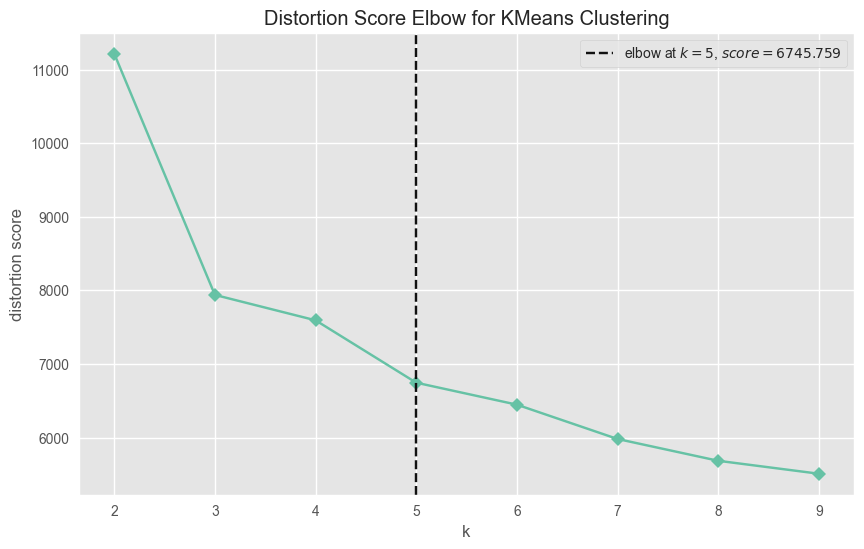

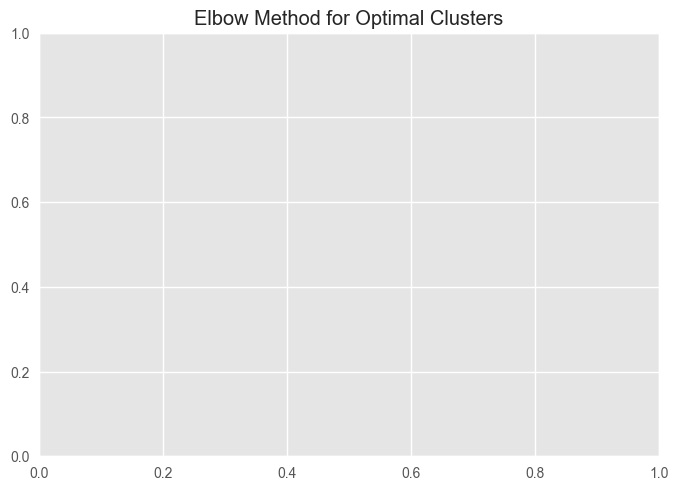

Optimal clusters: 5


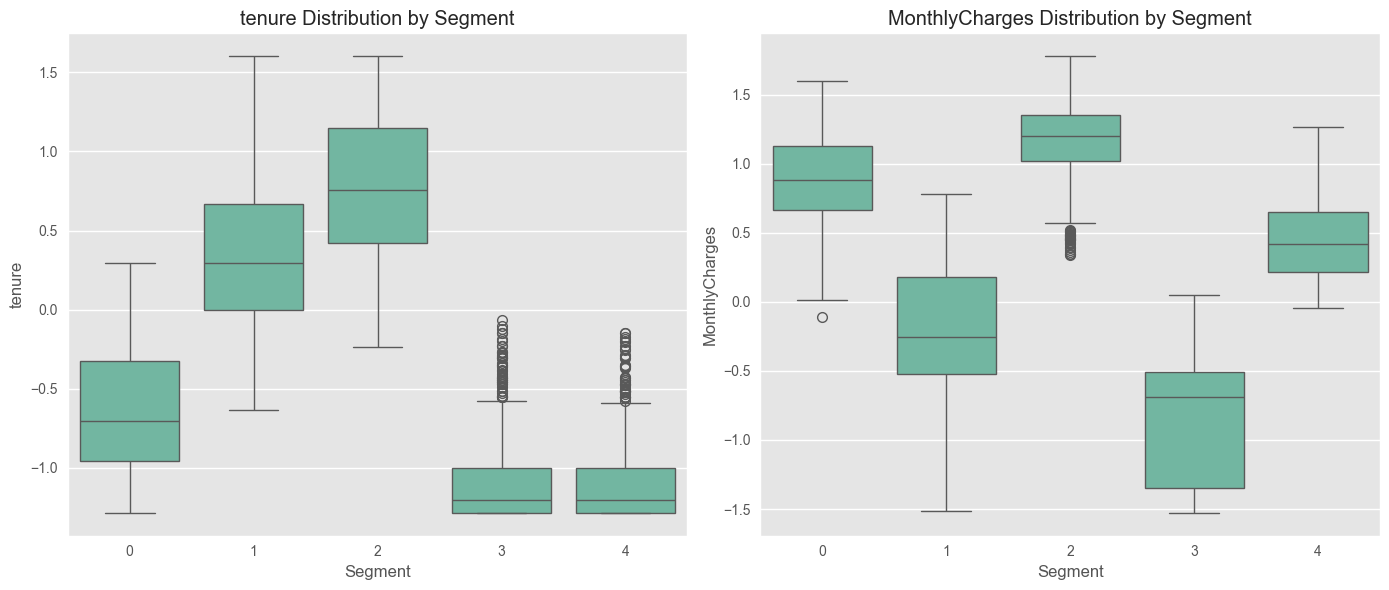

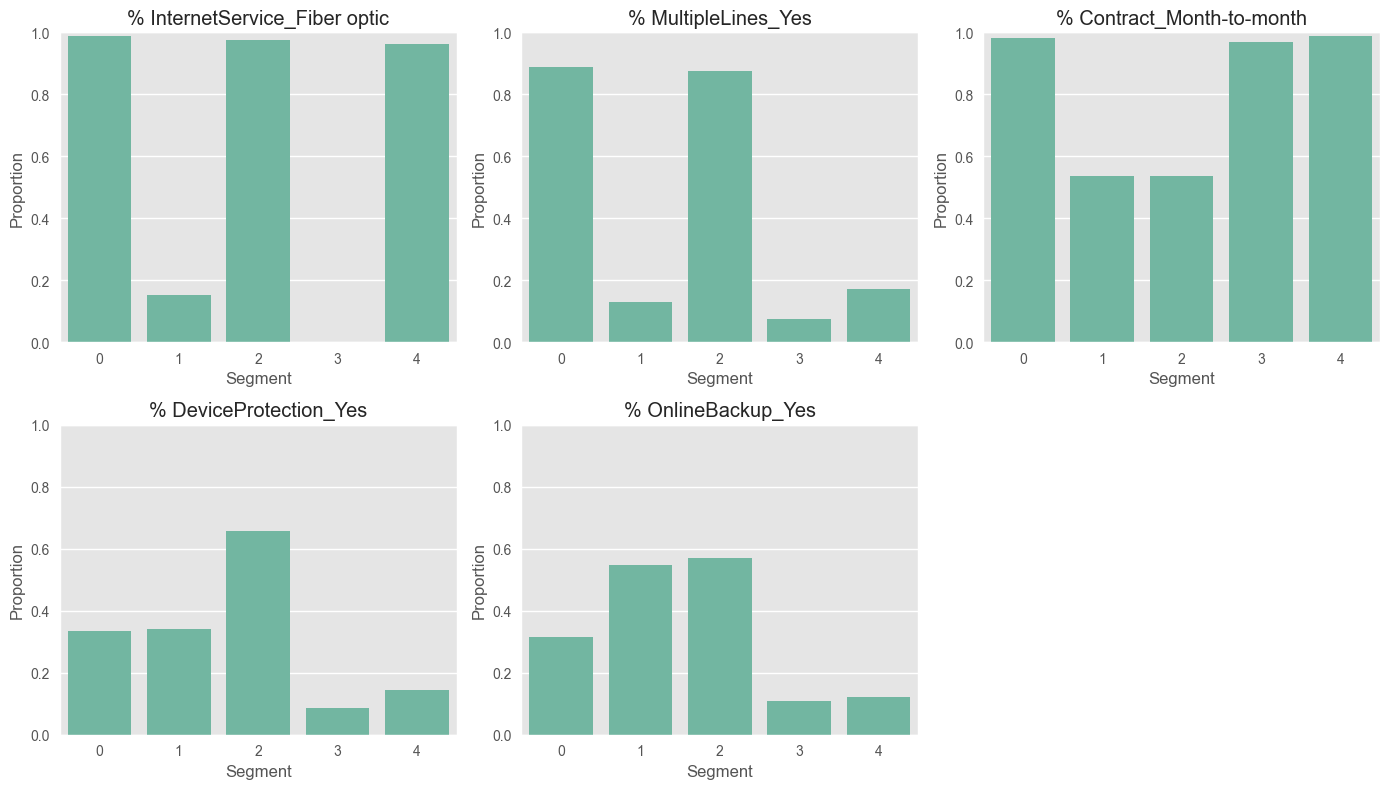


Segmentation completed. Cluster profiles:


,Segment,Segment_Label,Size,Pct_Total,tenure_mean,MonthlyCharges_mean
0,0,New-Budget-Partial-service,1188,27.073838,-0.638918,0.875181
1,1,New-Budget-Basic,254,5.788514,0.335474,-0.257028
2,2,New-Budget-Partial-service,661,15.063810,0.802637,1.163763
3,3,New-Budget-Basic,1044,23.792160,-1.100108,-0.890804
4,4,New-Budget-Partial-service,1241,28.281677,-1.106581,0.465047



Generating business reports...



Process completed successfully!


In [4]:
SEGMENTATION_FEATURES = [
    'SeniorCitizen', 'Dependents', 'MultipleLines_Yes',
    'InternetService_Fiber optic', 'OnlineBackup_Yes',
    'OnlineSecurity_Yes', 'DeviceProtection_Yes',
    'TechSupport_Yes', 'PaperlessBilling',
    'Contract_Month-to-month', 'tenure', 'MonthlyCharges'
]

print("Starting customer segmentation process...")

# Perform segmentation
churned_segmented, profiles = perform_customer_segmentation(
    df, 
    SEGMENTATION_FEATURES
)

# Display segmentation results
print("\nSegmentation completed. Cluster profiles:")
display(profiles[['Segment', 'Segment_Label', 'Size', 'Pct_Total', 
                    'tenure_mean', 'MonthlyCharges_mean']])

# Generate business reports
print("\nGenerating business reports...")
generate_segment_reports(profiles)

print("\nProcess completed successfully!")

